Requirements to run:

torch, matplotlib, opencv-python, tqdm, numpy

train_sims.npy, val_sims.npy, test_sims.npy (You may need to change the paths)

Data in 200x200 format with conductivity, pressure, and porosity. (Again, you may need to change path)

At the bottom in the evaluation section, there are some pre-named models. You should replace these with the names of your saved models.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import numpy as np

# Prevents crashes when showing graphs
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
# Pre-Determined train/test/val split
train_sims = np.load("../train_sims.npy")
train_sims = train_sims[train_sims < 250]
val_sims = np.load("../val_sims.npy")
val_sims = val_sims[val_sims < 250]
test_sims = np.load("../test_sims.npy")
test_sims = test_sims[test_sims < 250]

# Folders
BINARY_FOLDER = "../Data200x200_withinfo"
UNIFORM_FOLDER = "../Uniform200x200withInfo"

# Get porosity phi
def get_phi(sim,step,folder):
    return cv2.imread(f"{folder}/Image-{sim}-{step}_phi.jpg", cv2.IMREAD_GRAYSCALE)

# Get pressure
def get_pres(sim,step,folder):
    return cv2.imread(f"{folder}/Image-{sim}-{step}_P.jpg", cv2.IMREAD_GRAYSCALE)

# Get conductivity K
def get_k(sim,step,folder):
    return cv2.imread(f"{folder}/Image-{sim}-{step}_K.jpg", cv2.IMREAD_GRAYSCALE)

# Get all 3 as a 3-channel matrix
def get_all(sim,step,folder):
    return np.array((get_k(sim,step,folder), get_pres(sim,step,folder), get_phi(sim,step,folder)), dtype=np.float32)

In [ ]:
# Pre-define steps and points to maintain a consistent validation set
val_steps = np.random.randint(1,199,(val_sims.shape[0],))
val_points = np.random.randint(0,149,(val_sims.shape[0],2))
val_type = np.random.randint(0,2,(val_sims.shape[0],))

In [ ]:
# Darcy loss function
def darcy_loss(model, inp):
    # Takes in the k,pres,phi and outputs the prediction across the image.
    inp = inp.requires_grad_(True)
    out = model(inp)
    # out is in order K,P,phi, (conductivity, pressure, porosity)

    # Impose high pressure along the entire upper line by setting the pressure channelt to 200.
    out[:, 1:2, 0, :] = 200

    # If we assume the output is in order k,pres,phi
    # pres_grad is the gradient of the pressure along the y and x directions as a tuple
    pres_grad = torch.gradient(out[:, 1:2], dim=(-2,-1))

    # get velocity by multiplying the gradient by the conductivity
    y_grad = pres_grad[0] * out[:, 0:1]
    x_grad = pres_grad[1] * out[:, 0:1]

    # compute the divergence by the second derivative of the gradients and adding them together
    yy_grad = torch.gradient(y_grad, spacing=(1,),dim=(-2,))[0]
    xx_grad = torch.gradient(x_grad, spacing=(1,),dim=(-1,))[0]
    final = yy_grad + xx_grad

    # total divergence should be 0
    loss = (final**2).mean()

    return loss, out

In [ ]:
# Building Blocks of the Unet

class TwoConv(nn.Module):
    # Basic block with 2 convolutional layers, each with a batch norm and relu
    
    def __init__(self, in_channels, out_channels, no_end_relu=False):
        super().__init__()
        
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

        if no_end_relu:
            self.seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            )

    def forward(self, inp):
        return self.seq(inp)

# A single conv layer that will increase the height and width of the matrix by 2 each.
class SmallUp(nn.Module):

    def __init__(self, channels):
        super().__init__()

        self.conv = nn.Conv2d(channels, channels, 3, 1, 2)

    def forward(self, inp):
        return F.relu(self.conv(inp))

# A single conv layer that will decrease the height and width of the matrix by 2 each.
class SmallDown(nn.Module):

    def __init__(self, channels):
        super().__init__()

        self.conv = nn.Conv2d(channels, channels, 3, 1, 0)

    def forward(self, inp):
        return F.relu(self.conv(inp))
    
# Applies two convolutional layers, then pools
class Downsample(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv = TwoConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, inp):

        return self.pool(self.conv(inp))

# Upsamples and concatenates the upsampled matrix with the "across" then performs convolution on the result
class Upsample(nn.Module):

    def __init__(self, in_channels, out_channels, tweak=None):
        super().__init__()
        # Upsamples by 2x
        self.up = nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1)
        self.tweak = tweak
        self.conv_after = TwoConv(in_channels, out_channels)

    def forward(self, below, across):
        # First upsample by 2x
        upsampled = self.up(below)
        # If tweak is active, apply it first
        if not self.tweak == None:
            upsampled = self.tweak(upsampled)
        # Concatenate with the same size on the downswing of the unet
        concat = torch.concat((upsampled, across), dim=-3)
        # Convolute them together
        return self.conv_after(concat)
    
# Define the actual model used
class SmallUnet(nn.Module):
    
    def __init__(self):
        super().__init__()

        # Input is Nx3x200x200
        self.c1 = TwoConv(3, 8)
        self.d1 = Downsample(8,16) # 16x100x100
        self.d2 = Downsample(16,32) # 32x50x50
        self.su = nn.Sequential(
            SmallUp(32),
            SmallUp(32),
            SmallUp(32)
        ) # 3x56x56
        self.d3 = Downsample(32,64) # 64x28x28
        self.d4 = Downsample(64,128) # 128x14x14
        self.d5 = Downsample(128, 256) # 256x7x7

        # Now back up
        self.u1 = Upsample(256, 128) # 128x14x14
        self.u2 = Upsample(128, 64) # 64x28x28
        self.u3 = Upsample(64, 32, tweak=nn.Sequential(
            SmallDown(32),
            SmallDown(32),
            SmallDown(32)
        ))  # 32x50x50
        self.u4 = Upsample(32,16) # 16x100x100
        self.u5 = Upsample(16,8) # 8x200x200
        self.final = TwoConv(8, 3, no_end_relu=True)

    def forward(self, input):
        # Start with convolution, expand 3 channels to 8.
        # Then downsample 5 times, saving the result
        top = self.c1(input)
        x1 = self.d1(top)
        x2 = self.d2(x1)
        x3 = self.d3(self.su(x2)) # Here we upsample slightly so that we can downsample with less border artifacts
        x4 = self.d4(x3)
        x5 = self.d5(x4)
        # Now that we're at 256x7x7, we upsample from here.
        # At each layer with concatenate with the xi that is the same size as the up after upsampling.
        up = self.u1(x5, x4)
        up = self.u2(up, x3)
        up = self.u3(up, x2) # Again, a small downsample here to get back on the proper resolution
        up = self.u4(up, x1)
        up = self.u5(up, top)
        # One last convolution on the result to return to 3 channels from 8, leaving us with the proper 3x200x200
        return self.final(up)

In [ ]:
# Dataset used
class MaskedDataset(torch.utils.data.Dataset):

    def __init__(self,
                 sims,
                 unmask_size=20,
                 points = None,
                 block_size = 50,
                 reveal_strategy = "block",
                 n_points = 200,
                 radius = 2,
                 steps = None,
                 H=200,
                 W=200,
                 channels="all",
                 mixed=False,
                 types=None,
                 noise=5,
                 return_mask=False,                 # allows visualiztion of mask
                 reveal_dim=[[(0, 1)], [(0, 1)]],   # x,y range for disks to exist
                 jitter_std=0.0,                    # % each disk drifts from deterministic position
                 deterministic_mask=True            # if True, mask is deterministic and noise is 0. True for testing
                 ):
        
        self.sims = sims
        self.points = points
        self.steps = steps
        self.size = unmask_size
        self.reveal_strategy = reveal_strategy
        self.block_size = block_size
        self.n_points = n_points
        self.radius = radius
        self.H, self.W = H, W
        self.channels = channels
        self.mixed = mixed
        self.types = types
        self.noise = noise
        self.return_mask = return_mask
        self.reveal_dim = reveal_dim
        self.jitter_std = jitter_std
        self.deterministic_mask = deterministic_mask

    def _chan_idx(self):
        if self.channels == "all":
            return [0,1,2]
        elif self.channels == "K":
            return [0]
        elif self.channels == "P":
            return [1]
        elif self.channels == "phi":
            return [2]
        else:
            raise ValueError("channels must be 'all', 'K', 'P', or 'phi'")
        

    def __getitem__(self, index):
        chans = self._chan_idx()


        if not type(self.steps) == np.ndarray:
            step = np.random.randint(1,200)
        else:
            step = self.steps[index]

        if self.mixed:
            if not type(self.types) == np.ndarray:
                kind = np.random.randint(0,2)
            else:
                kind = self.types[index]
        else:
            kind = 0
        if kind == 0:
            folder = BINARY_FOLDER
        else:
            folder = UNIFORM_FOLDER

        # Create tensor for the target
        t = torch.tensor(get_all(self.sims[index], step, folder))

        # Create 0-matrix
        z = torch.zeros_like(t)

        # build a boolean mask of revealed pixels, shape (H,W)
        mask = torch.zeros((self.H, self.W), dtype=torch.bool)

        if self.reveal_strategy == "block":
            # choose top-left for the block
            if not type(self.points) == np.ndarray:
                i0 = np.random.randint(0, self.H - self.block_size + 1)
                j0 = np.random.randint(0, self.W - self.block_size + 1)
            else:
                i0, j0 = self.points[index]
                i0 = max(0, min(i0, self.H - self.block_size))
                j0 = max(0, min(j0, self.W - self.block_size))
            mask[i0:i0+self.block_size, j0:j0+self.block_size] = True


            # new disk mask method
            # deterministic disk strategy
        elif self.reveal_strategy == "disks":

            # used for reveal_dim
            # map fraction [0,1] to pixel indices [0, N-1] in mask layer
            def _segments_to_indices(segments, N, pad=0):
                idxs = []
                for a, b in segments:
                    i0 = max(pad, int(round(a * (N - 1))))
                    i1 = min((N - 1) - pad, int(round(b * (N - 1))))
                    if i1 >= i0:
                        idxs.append(torch.arange(i0, i1 + 1, dtype=torch.long))
                if not idxs:
                    # fallback to full range
                    return torch.arange(pad, N - pad, dtype=torch.long)
                return torch.unique(torch.cat(idxs)).to(torch.long)

            row_fracs = self.reveal_dim[0] # e.g, [(0, 1)]
            col_fracs = self.reveal_dim[1] # e.g, [(0, 1)]
            row_allowed = _segments_to_indices(row_fracs, self.H, pad=self.radius)
            col_allowed = _segments_to_indices(col_fracs, self.W, pad=self.radius)

            # choose grid shape close to aspect ratio 
            # works with non-squares
            Hspan = (row_allowed[-1] - row_allowed[0] + 1) if len(row_allowed) > 0 else self.H
            Wspan = (col_allowed[-1] - col_allowed[0] + 1) if len(col_allowed) > 0 else self.W
            ratio = float(Wspan) / max(1.0, float(Hspan))
            ny = int(max(1, round(np.sqrt(self.n_points / max(1e-8, ratio)))))
            nx = int(max(1, round(self.n_points / ny)))
            while nx * ny < self.n_points:
                nx += 1

            # pick evenly spaced indices from rows/cols allowed
            def pick_lin_indices(allowed, k):
                if k <= 1:
                    return allowed[len(allowed)//2]
                pos = torch.linspace(0, len(allowed)-1, steps=k)
                idx = torch.round(pos).long()
                return allowed[idx]
            
            
            row_picks = pick_lin_indices(row_allowed, ny)
            col_picks = pick_lin_indices(col_allowed, nx)
            yy, xx = torch.meshgrid(row_picks, col_picks, indexing="ij")
            points = torch.stack([yy.reshape(-1), xx.reshape(-1)], dim=1) # (ny*nx, 2)
            
            # if more than n_points, subselect
            if points.shape[0] > self.n_points:
                sel_pos = torch.linspace(0, points.shape[0]-1, steps=self.n_points)
                sel_idx = torch.round(sel_pos).long()
                points = points[sel_idx]

            ii = points[:, 0]
            jj = points[:, 1]

            if not self.deterministic_mask:
                if self.jitter_std is not None and self.jitter_std > 0:
                    # convert std (like 0.01 of image size) to pixels
                    sigmaH = float(self.jitter_std) * self.H
                    sigmaW = float(self.jitter_std) * self.W
                    
                    # Add Gaussian noise in pixel units
                    ii = ii.to(torch.float32) + torch.randn_like(ii, dtype=torch.float32) * sigmaH
                    jj = jj.to(torch.float32) + torch.randn_like(jj, dtype=torch.float32) * sigmaW

                    # Round and clamp so they stay inside bounds
                    ii = ii.round().clamp(self.radius, self.H - 1 - self.radius).to(torch.long)
                    jj = jj.round().clamp(self.radius, self.W - 1 - self.radius).to(torch.long)




            yy, xx = torch.meshgrid(torch.arange(self.H), torch.arange(self.W), indexing="ij")
            for y0, x0 in zip(ii, jj):
                disk = (yy - int(y0))**2 + (xx - int(x0))**2 <= (self.radius**2)
                mask |= disk
        else:
            raise ValueError(f"Unknown reveal_strategy: {self.reveal_strategy}")
        

        if not self.deterministic_mask: # only when non deterministic
            obs = t[chans].clone()
            # Add Gausian noise (0 - 255 scale)
            if self.noise is not None and self.noise > 0:
                sigma = float(self.noise)
                obs = obs + sigma * torch.randn_like(obs)
                obs.clamp_(0.0, 255.0)
            t = obs[chans].clone()
    
        

        # write revealed pixels for selected channels
        chans = self._chan_idx()
        z[chans, :, :] = torch.where(mask, t[chans, :, :], torch.zeros_like(t[chans, :, :]))

        if self.return_mask:
            return z,t, mask
        else:  
            return z,t
    
    def __len__(self):
        return self.sims.shape[0]
    
train_loader = torch.utils.data.DataLoader(MaskedDataset(train_sims,
                                                         reveal_strategy="disks",
                                                         n_points=12,
                                                         radius=5,
                                                         mixed=True),
                                                         batch_size=8, shuffle=True)
# Val uses preset points and steps
val_data = MaskedDataset(
    val_sims,
    reveal_strategy="disks",
    n_points=12,
    radius=5,
    points=val_points,
    steps=val_steps,
    mixed=True,
    types=val_type
)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=8)

In [ ]:
model = SmallUnet().to(device)
optim = torch.optim.Adam(model.parameters())
schedule = torch.optim.lr_scheduler.ExponentialLR(optim, 0.99)
crit = nn.MSELoss()

In [ ]:
# Parameter count
sum([k.numel() for k in model.parameters()])

2527461

In [ ]:
# Pick epoch dount
epochs = 250
# train loss values, losses is total darcy is only darcy
losses = []
darcy = []
# similar for validation
val_loss = []
val_darcy = []

for e in tqdm(range(epochs)):
    epoch_loss = 0
    epoch_darcy = 0
    for feat,label in train_loader:
        optim.zero_grad()
        feat = feat.to(device)
        label = label.to(device)
        # Process darcy loss and save it
        p_loss, out = darcy_loss(model, feat)
        epoch_darcy += p_loss.item()
        # Calculate total loss
        loss = p_loss + crit(out[:,:2], label[:,:2])
        epoch_loss += loss.item()
        # Perform backward step
        loss.backward()
        optim.step()
    # Track loss
    epoch_loss /= train_loader.__len__()
    epoch_darcy /= train_loader.__len__()
    losses.append(epoch_loss)
    darcy.append(epoch_darcy)

    schedule.step()

    epoch_loss = 0
    epoch_darcy = 0
    with torch.no_grad():
        for feat,label in val_loader:

            feat = feat.to(device)
            label = label.to(device)
            p_loss, out = darcy_loss(model, feat)
            epoch_darcy += p_loss.item()
            loss = p_loss + crit(out[:,:2], label[:,:2])
            epoch_loss += loss.item()

    epoch_loss /= val_loader.__len__()
    epoch_darcy /= val_loader.__len__()
    val_loss.append(epoch_loss)
    val_darcy.append(epoch_darcy)

  0%|          | 0/250 [00:03<?, ?it/s]


KeyboardInterrupt: 

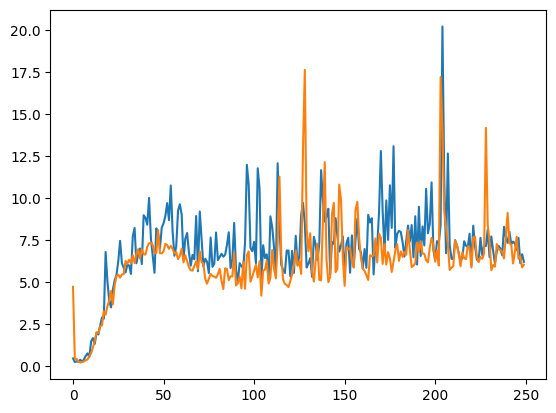

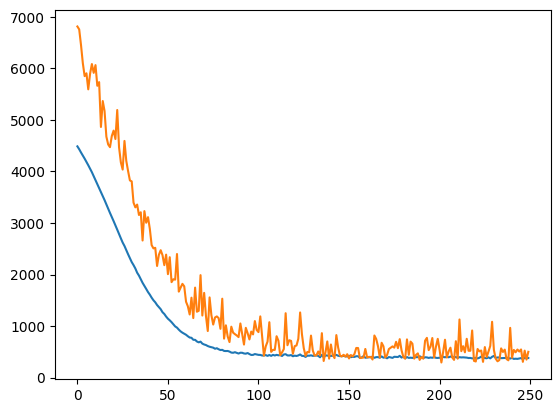

In [ ]:
plt.plot(np.array(val_darcy))
plt.plot(np.array(darcy))
plt.show()
plt.plot(np.array(val_loss) - np.array(val_darcy))
plt.plot(np.array(losses) - np.array(darcy))
plt.show()

In [ ]:
torch.save(model, "mixed/small_unet_mixed_disk.pt")

Now to actual evaluation

In [ ]:
# both_model = torch.load("small_unet_darcy_50_both-b1.pt", weights_only=False).to(device)
# darcy_model = torch.load("small_unet_darcy_50_nomse.pt", weights_only=False).to(device)
# mse_model = torch.load("small_unet_darcy_50_nodarcy.pt", weights_only=False).to(device)

In [ ]:
def vis(tensor):
    return tensor.cpu().detach().numpy()

def show_evaluation(model, indices, data=val_data):

    fig, axs = plt.subplots(len(indices), 6, dpi=600)

    axs[0,0].set_title("Given K", fontsize=8)
    axs[0,1].set_title("Predicted K",fontsize=8)
    axs[0,2].set_title("Actual K",fontsize=8)

    axs[0,3].set_title("Given Pres",fontsize=8)
    axs[0,4].set_title("Predicted Pres",fontsize=8)
    axs[0,5].set_title("Actual Pres",fontsize=8)

    for i,e in enumerate(indices):
        sample = val_data.__getitem__(e)
        out = model(sample[0].to(device).unsqueeze(0))[0]

        axs[i,0].imshow(vis(sample[0][0]), cmap='gray', vmin=0, vmax=255)
        axs[i,1].imshow(vis(out[0]), cmap='gray', vmin=0, vmax=255)
        axs[i,2].imshow(vis(sample[1][0]), cmap='gray', vmin=0, vmax=255)

        axs[i,3].imshow(vis(sample[0][1]), cmap='gray', vmin=0, vmax=255)
        axs[i,4].imshow(vis(out[1]), cmap='gray', vmin=0, vmax=255)
        axs[i,5].imshow(vis(sample[1][1]), cmap='gray', vmin=0, vmax=255)

    for axs in fig.get_axes():
        axs.axis('off')
    fig.tight_layout()
    plt.show()

In [ ]:
# Model using only darcy loss
# show_evaluation(darcy_model, [9,6,12,17])

In [ ]:
# Model using only darcy loss
# show_evaluation(mse_model, [9,6,12,17])

In [ ]:
val_type

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0], dtype=int32)

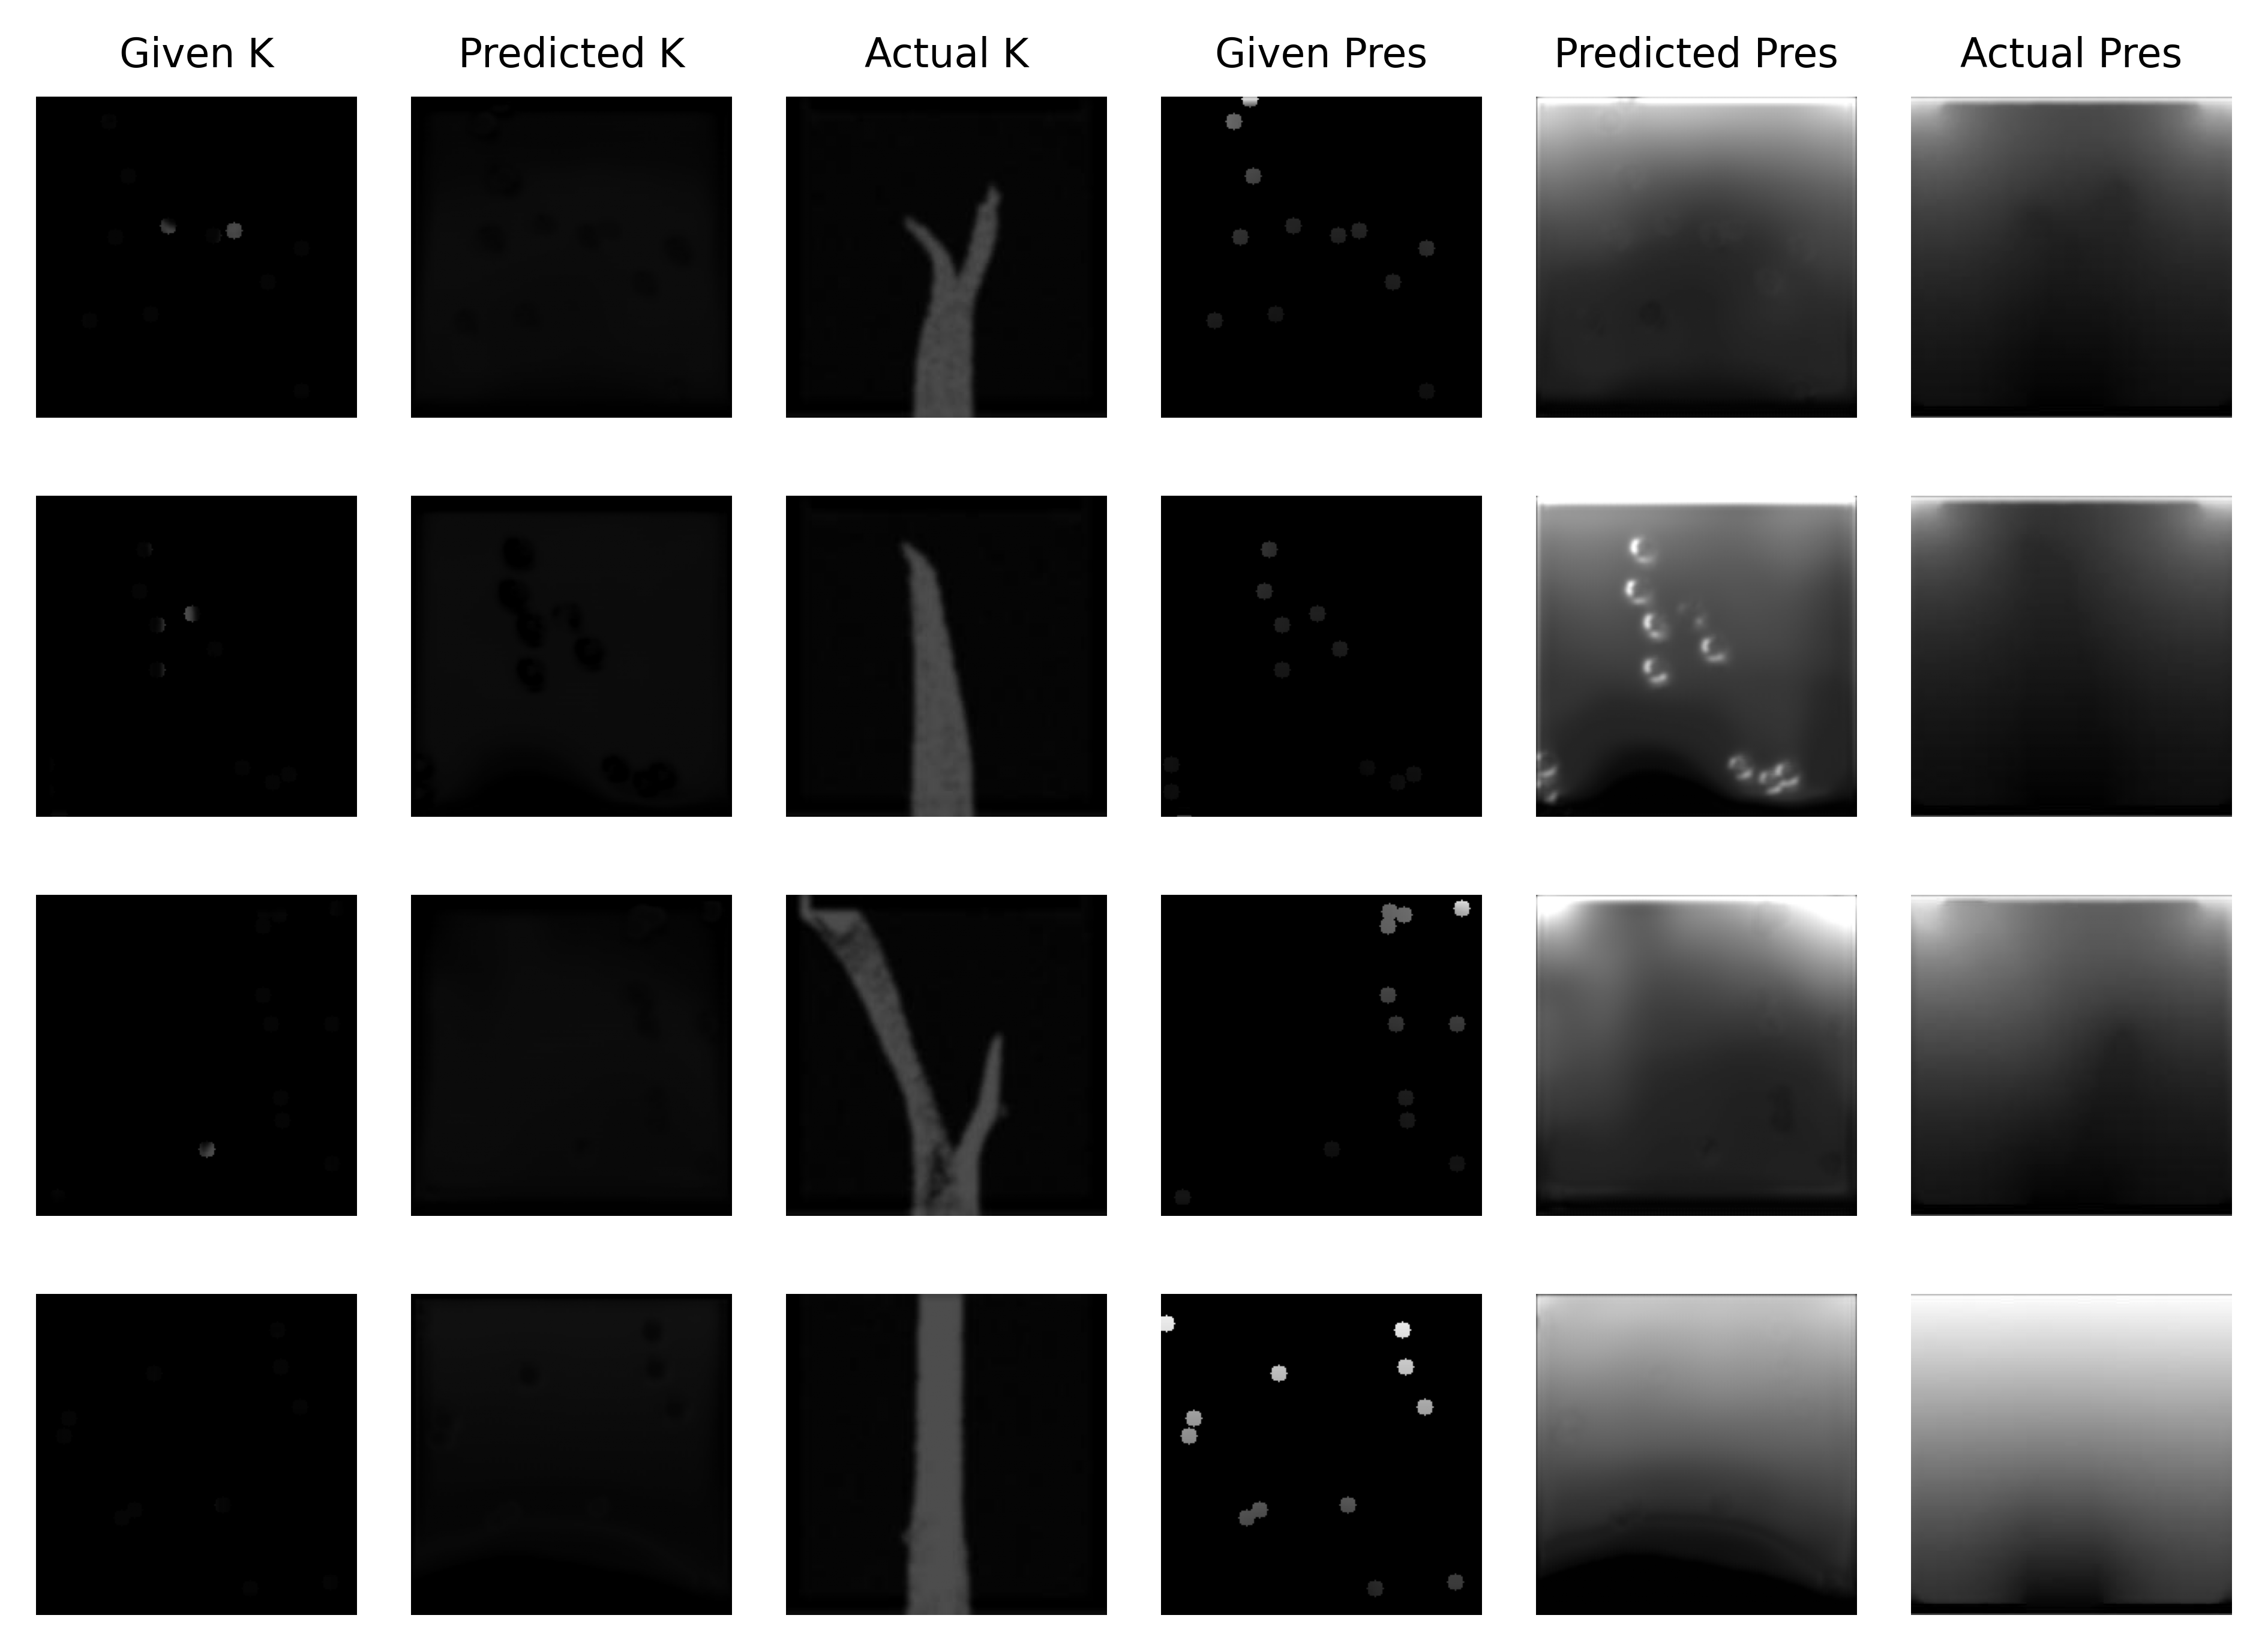

In [ ]:
show_evaluation(model, [10,2,12,4])

torch.Size([3, 200, 200]) torch.Size([3, 200, 200]) torch.Size([200, 200])


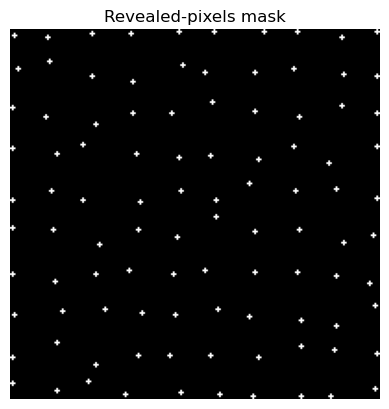

In [ ]:
# build the dataset (as you did)
val_data = MaskedDataset(
    val_sims,
    reveal_strategy="disks",
    n_points=100,
    radius=1,
    noise=0,
    reveal_dim=[[(0, 1)],[(0, 1.00)]],   # full image for both dims
    return_mask=True,
    jitter_std = 0.015,
    deterministic_mask = False

)

z, t, mask = val_data[0]
print(z.shape, t.shape, mask.shape)  # expect (3,200,200), (3,200,200), (200,200)

import matplotlib.pyplot as plt
plt.imshow(mask.numpy(), cmap="gray")
plt.title("Revealed-pixels mask")
plt.axis("off")
plt.show()